## First, lets join our tables etc..

In [751]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import plotly.express as px
import seaborn as sns
from sklearn import preprocessing
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix
from sklearn.utils import resample


pd.set_option('display.max_columns', None)

In [752]:
complaints_df = pd.read_pickle('../pickle/complaints_v2.pkl')
reports_df = pd.read_pickle('../pickle/reports.pkl')

In [753]:
#add a url feature to match with reports_df
complaints_df['url'] = complaints_df.apply(lambda x: x.complaints['url'],axis=1)
reports_df['url'] = reports_df.apply(lambda x: x.complaints['url'],axis=1)


In [754]:
df = reports_df.merge(complaints_df, on='url')
df_t = df.drop_duplicates('url').copy()

In [722]:
df_t = df_t[['direction_x','street_type_x',
                'latitude_x','longitude_x','permits','tanks',
                'neshaps_demolition_notices','holds',
                'complaint_type','street_number_x','enforcement']]

In [723]:
# these are features where a Nan value indicates 0 and all other values indicate 1. 
# Making this adjustment now
dict_columns = ['enforcement','permits','tanks','neshaps_demolition_notices','holds']
for i in dict_columns:
    df_t[i] = df_t[i].apply(lambda x: 1 if type(x) == dict else 0 )

In [724]:
# applying a very hacky encodder
categorical = ['direction_x','street_type_x','complaint_type']
le = preprocessing.LabelEncoder()
for c in categorical:
    df_t[c] = df_t[c].apply(str).astype('category')
    #le = preprocessing.LabelEncoder()
    le.fit(df_t[c])
    df_t[c] = le.transform(df_t[c])

In [725]:
#drop rows with missing values, 
before = df_t.shape[0]
df_t = df_t.dropna(axis=0)
print(f"Dropped {before - df_t.shape[0]} rows")

Dropped 236 rows


In [726]:
#We have a major issue regarding sampling
# Separate majority and minority classes
df_majority = df_t[df_t.enforcement==0]
df_minority = df_t[df_t.enforcement==1]
 
# Upsample minority class
df_minority_upsampled = resample(df_minority, 
                                 replace=True,     # sample with replacement
                                 n_samples=28673,    # to match majority class
                                 random_state=123) # reproducible results
 
# Combine majority class with upsampled minority class
df_upsampled = pd.concat([df_majority, df_minority_upsampled])
 
# Display new class counts
df_upsampled.enforcement.value_counts()
# 1    576
# 0    576
# Name: balance, dtype: int64

1    28673
0    28673
Name: enforcement, dtype: int64

In [727]:
df_t = df_upsampled

In [729]:
# converting object types to floats,ints
categories = {'latitude_x':float,'longitude_x':float,'street_number_x':int}
for c in categories:
    df_t[c] = df_t[c].apply(categories[c])

In [730]:
#checking for NaN values
for i in df_t_features.columns:
    print(i,np.any(np.isnan(df_t[i])))

direction_x False
street_type_x False
latitude_x False
longitude_x False
permits False
tanks False
neshaps_demolition_notices False
holds False
complaint_type False
street_number_x False


In [712]:
df_t_features = df_t.drop('enforcement',axis=1)
df_t_target = df_t[['enforcement']]

In [713]:
X_train, X_test, y_train, y_test =  train_test_split(df_t_features,df_t_target, test_size=0.2)


### Testing a simple decision tree

In [714]:
dt = DecisionTreeClassifier(max_depth=12,random_state=0)
dt.fit(X_train, y_train)
predictions = dt.predict(X_test)
print(f'Accuracy: {dt.score(X_test,y_test)}\n')
confusion_matrix(y_test,predictions)

Accuracy: 0.7606800348735833



array([[4512, 1328],
       [1417, 4213]])

In [738]:
data = {'y_Actual':    list(y_test.enforcement),
        'y_Predicted': predictions
        }

df = pd.DataFrame(data, columns=['y_Actual','y_Predicted'])
confusion_matrix = pd.crosstab(df['y_Actual'], df['y_Predicted'], rownames=['Actual'], colnames=['Predicted'])
#sns.heatmap(confusion_matrix, annot=True)
print(confusion_matrix)

Predicted     0     1
Actual               
0          4512  1328
1          1417  4213


### Testing a random forest

In [739]:
clf = RandomForestClassifier(max_depth=15, random_state=0)
clf.fit(X_train, y_train)
prediction = clf.predict(X_test)
print(f'Accuracy: {clf.score(X_test,y_test)}\n')

/usr/local/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning:

The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:2: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().



Accuracy: 0.861900610287707



In [740]:
data = {'y_Actual':    list(y_test.enforcement),
        'y_Predicted': prediction
        }

df = pd.DataFrame(data, columns=['y_Actual','y_Predicted'])
confusion_matrix = pd.crosstab(df['y_Actual'], df['y_Predicted'], rownames=['Actual'], colnames=['Predicted'])
#sns.heatmap(confusion_matrix, annot=True)
print(confusion_matrix)

Predicted     0     1
Actual               
0          4995   845
1           739  4891


In [741]:
d = dict(zip(clf.feature_importances_, df_t_features.columns))
for elem in sorted(d.items(),reverse=True) :
    print(f'{elem[1]}: {round(elem[0],6)} ')

permits: 0.199199 
latitude_x: 0.196179 
longitude_x: 0.189617 
street_number_x: 0.179609 
complaint_type: 0.093843 
neshaps_demolition_notices: 0.045226 
tanks: 0.040805 
street_type_x: 0.029245 
direction_x: 0.020203 
holds: 0.006073 


## A Look at SMOTE resampling


In [742]:
from imblearn.over_sampling import SMOTE # doctest: +NORMALIZE_WHITESPACE

Using TensorFlow backend.


In [743]:
sm = SMOTE(random_state=42)

In [744]:
X_res, y_res = sm.fit_resample(df_t_features, df_t_target)


/usr/local/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().



In [746]:
X_train1, X_test1, y_train1, y_test1 =  train_test_split(X_res,y_res, test_size=0.2)
clf = RandomForestClassifier(max_depth=15, random_state=0)
clf.fit(X_train1, y_train1)
prediction = clf.predict(X_test1)
print(f'Accuracy: {clf.score(X_test1,y_test1)}\n')

/usr/local/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning:

The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.



Accuracy: 0.8524847428073234



In [750]:
data = {'y_Actual':    list(y_test1),
        'y_Predicted': prediction
        }

df = pd.DataFrame(data, columns=['y_Actual','y_Predicted'])
confusion_matrix = pd.crosstab(df['y_Actual'], df['y_Predicted'], rownames=['Actual'], colnames=['Predicted'])
#sns.heatmap(confusion_matrix, annot=True)
print(confusion_matrix)

Predicted     0     1
Actual               
0          4852   825
1           867  4926


## Simple visualization

The logitude and Latitude carry significant importance regarding whether a complaint is enforced or not.  So lets visually try to understand if there are certain parts of the city where a complaint hsa higher "importance"

In [717]:
# I will plot every point using its coordinates and mark it red or blue based on if it was enforced or not


In [670]:
BBox = ((df_t.longitude_x.min(),   max(i for i in df_t.longitude_x if i < 0),      
         min(i for i in df_t.latitude_x if i > 0.0), df_t.latitude_x.max()))

In [671]:
BBox

(-87.91443584831512, -87.52467915139687, 41.64471104296954, 42.02266893033332)

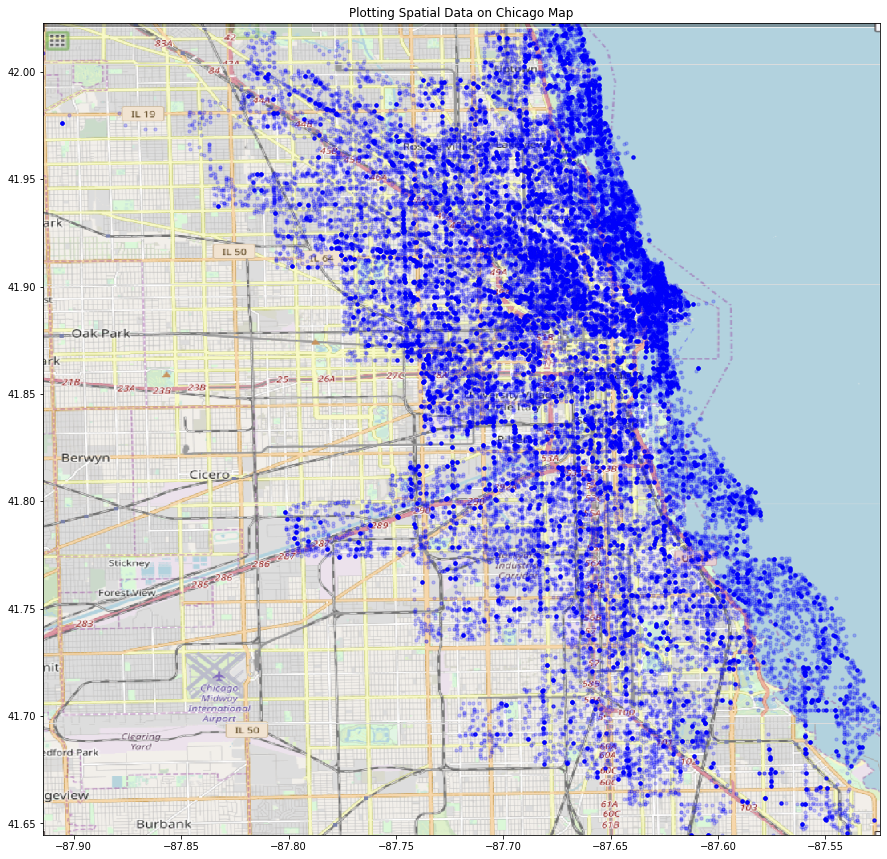

In [673]:
ruh_m = plt.imread('../images/chicago.png')


fig, ax = plt.subplots(figsize = (15,15))
ax.scatter(df_t.longitude_x, df_t.latitude_x, zorder=1, alpha= 0.2, c='b', s=10)
ax.set_title('Plotting Spatial Data on Chicago Map')
ax.set_xlim(BBox[0],BBox[1])
ax.set_ylim(BBox[2],BBox[3])

ax.imshow(ruh_m, zorder=0, extent = BBox, aspect= 'equal')


### OK THAT WAS A WASTE OF TIME, openstreetview isnt good for large areas. Well I didnt seem to get it to work well so i screenshot a rough version and it really is not percise ...... next we will try plot.ly

## Plot.ly 

In [675]:
px.set_mapbox_access_token(open("../.mapbox_token").read())


In [676]:
fig = px.scatter_mapbox(df_t, lat="latitude_x", lon="longitude_x",     
                        color="enforcement", 
                        color_discrete_map=px.colors.cyclical.IceFire_r,
                       title='*****Upsampled*****')
fig.update_layout(
    autosize=False,
    width=900,
    height=900)
fig.show()
